In [44]:
include("./src/gravity-tools.jl")
include("./src/trade-environment.jl")
include("./src/sim_trade_pattern_ek.jl")
using CSV
using DataFrames
using Plots
using MINPACK

## Step 1 Bulid the Eaton and Kortum (2002) dataset

Honestly, this came from my MATLAB code as a PHD student. The issue now is the Econometrica replication files are in GAUSS...

In [2]:
################################################################
# builds the EK dataset

dftrade = DataFrame(CSV.File("./ek-data/ek-data.csv"))

dflang = DataFrame(CSV.File("./ek-data/ek-language.csv"))

dflabor = DataFrame(CSV.File("./ek-data/ek-labor.csv"))

filter!(row -> ~(row.trade ≈ 1.0), dftrade);

filter!(row -> ~(row.trade ≈ 0.0), dftrade);

dftrade = hcat(dftrade, dflang);

#dfcntryfix = select(dftrade,Not("trade"))
dfcntryfix = DataFrame(CSV.File("./ek-data/ek-cntryfix.csv"));

Then this code makes a ``gravity_parameters`` structure that is used in the computation of the model

In [3]:
grv_params = gravity_params(L = dflabor.L, dfcntryfix = dfcntryfix)

gravity_params
  Ncntry: Int64 19
  θ: Float64 4.0
  L: Array{Float64}((19,)) [0.054, 0.024, 0.029, 0.094, 0.017, 0.019, 0.181, 0.0225, 0.025, 0.159, 0.544, 0.043, 0.01, 0.015, 0.026, 0.1, 0.031, 0.186, 1.0]
  dfcntryfix: DataFrame


## Step 2

This runs the "Gravity Regression" (equation (28)) with the trade cost specification in equation (29). 

The function ``gravity`` runs a Fixed Effect Model (using that package in Julia) and then normalizes the coefficients per Eaton and Kortum's normalization (see footnote of Table III). 

The output ``grvdata`` is a structure with the estimated coefficients.

In [4]:
grvdata = gravity(dftrade, display = true);


                                 FixedEffectModel                                 
Number of obs:                       342   Converged:                          true
dof (model):                           9   dof (residuals):                     295
R²:                                0.976   R² adjusted:                       0.972
F-statistic:                     87.9716   P-value:                           0.000
R² within:                         0.729   Iterations:                            4
                 Estimate  Std. Error      t-stat  Pr(>|t|)   Lower 95%   Upper 95%
───────────────────────────────────────────────────────────────────────────────────
bin375          3.45649      0.204755   16.8811      <1e-44    3.05353     3.85946
bin750          2.89299      0.167308   17.2914      <1e-46    2.56372     3.22226
bin1500         2.52554      0.156294   16.1589      <1e-41    2.21795     2.83313
bin3000         2.34086      0.20072    11.6623      <1e-25    1.94583     2.735

## Step 3

This next step recovers the primitives from the gravity coeffecients. Each function does what it says...gets the trade costs, gets the technology term. And all this is given a $\theta$. 

In [6]:
# ################################################################
# # Recover the trade costs and technology parameters

θ = 4.0

d = zeros(19,19)
T = zeros(19)
W = ones(19)

make_trade_costs!(grvdata, d, grv_params)

make_technology!(grvdata, T, W, grv_params)

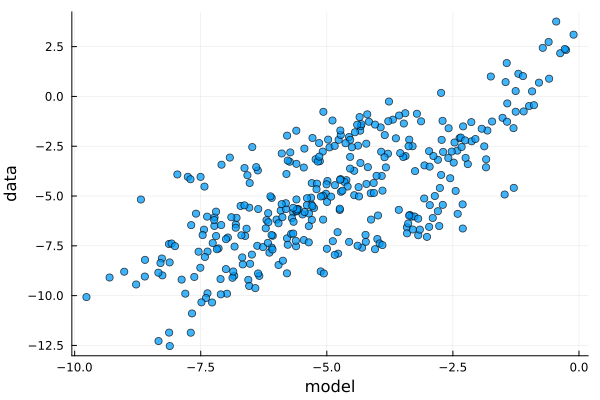

In [49]:
πshares, foo = sim_trade_pattern_ek(exp.(-grvdata.S), d, 4.0, 1.5, 100)

trademodel = log.(vec(normalize_by_home_trade(πshares, grv_params.Ncntry)'))

dfmodel = DataFrame(trade = trademodel)

filter!(row -> ~(row.trade ≈ 1.0), dfmodel);

filter!(row -> ~(row.trade ≈ 0.0), dfmodel);

plot(dfmodel.trade, dftrade.trade, seriestype = :scatter, alpha = 0.75,
    xlabel = "model",
    ylabel = "data",
    legend = false)